<a href="https://colab.research.google.com/github/namanphy/END2/blob/main/S7/Part%202%20-%20seq2seq/QA_dataset_Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/namanphy/END2.git --quiet
! pip install OmegaConf --quiet

     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 645kB 37.9MB/s 
     |████████████████████████████████| 112kB 54.3MB/s 


In [2]:
cd /content/END2/S7/Part\ 2\ -\ seq2seq

/content/END2/S7/Part 2 - seq2seq


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Model prep
import torch
import torch.nn as nn

# Data Prep
from torchtext.legacy.data import Field, BucketIterator
from torchtext.legacy import data
from data import make_qa_dataset

#Trainer
from trainer.optimizer import adam_optimizer
from trainer.qa_train import train as Trainer

# Utils
import random
from omegaconf import OmegaConf

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Preparation

**Dataset Info** - This dataset includes Wikipedia articles, factual questions manually generated from them, and answers to these manually generated questions for use in academic research.

The file "question_answer_pairs.txt" contains the questions and answers. The first line of the file contains 
column names for the tab-separated data fields in the file. This first line follows:

1. Field 1 - **ArticleTitle** - It is the name of the Wikipedia article from which questions and answers initially came.
2. Field 2 - **Question** - It is the question.
3. Field 3 - **Answer** - It is the answer.
4. Field 4 - **DifficultyFromQuestioner** - It is the prescribed difficulty rating for the question as given to the question-writer. 
5. Field 5 - **DifficultyFromAnswerer** - It is a difficulty rating assigned by the individual who evaluated and answered the question, which may differ from the difficulty in field 4.
6. Field 6 - **ArticleFile** - It is the relative path to the prefix of the article files. html files (.htm) and cleaned 
text (.txt) files are provided.

In [6]:
dataset = make_qa_dataset()

False
created dataset folder :  ../dataset/
Complete file path :../dataset/Question_Answer_Dataset_v1.2/S08/question_answer_pairs.txt
Complete file path :../dataset/Question_Answer_Dataset_v1.2/S10/question_answer_pairs.txt
Complete file path :../dataset/Question_Answer_Dataset_v1.2/S09/question_answer_pairs.txt

Removing Null values ..
Final dataset shape :  (3422, 6)
Preprocessing the dataset - lowercase, trim, and remove non-letter characters
Done.


In [7]:
dataset.head()

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Abraham_Lincoln,was abraham lincoln the sixteenth president of...,yes,easy,easy,data/set3/a4
1,Abraham_Lincoln,was abraham lincoln the sixteenth president of...,yes .,easy,easy,data/set3/a4
2,Abraham_Lincoln,did lincoln sign the national banking act of ?,yes,easy,medium,data/set3/a4
3,Abraham_Lincoln,did lincoln sign the national banking act of ?,yes .,easy,easy,data/set3/a4
4,Abraham_Lincoln,did his mother die of pneumonia ?,no,easy,medium,data/set3/a4


### Tokenizing, making Fields

In [8]:
question = Field(tokenize = 'spacy', 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

answer = Field(tokenize = 'spacy', 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)


fields = [('questions', question),('answers',answer)]

In [9]:
examples = [data.Example.fromlist([str(dataset.Question[i]),str(dataset.Answer[i])], fields) for i in range(dataset.shape[0])]
QA_Dataset= data.Dataset(examples, fields)

In [10]:
(train, test) = QA_Dataset.split(split_ratio=[0.7,0.3], random_state=random.seed(SEED))

print(f"Train Shape: {len(train.examples)}")
print(f"Test Shape: {len(test.examples)}")

Train Shape: 2395
Test Shape: 1027


In [11]:
# Printing one sample

print('QUESTION: ', vars(train.examples[0])['questions'])
print('ANSWERS: ', vars(train.examples[0])['answers'])

QUESTION:  ['what', 'was', 'the', 'faraday', 'effect', 'first', 'called', '?']
ANSWERS:  ['diamagnetism']


### Building Vocabulary

In [12]:
question.build_vocab(train, min_freq = 3)
answer.build_vocab(train, min_freq = 3)

In [13]:
print('Size of input vocab : ', len(question.vocab))
print('Size of label vocab : ', len(answer.vocab))
print('Top 10 words appreared repeatedly :', list(question.vocab.freqs.most_common(10)))

Size of input vocab :  1095
Size of label vocab :  597
Top 10 words appreared repeatedly : [('?', 2353), ('the', 1384), ('of', 801), ('is', 721), ('what', 611), ('in', 533), ('a', 471), ('was', 371), ('did', 348), ('are', 285)]


# Setting Config and loading BucketIterator

In [14]:
hparams = OmegaConf.create({
    'epochs':10,
    'batch_size':128,
    'learning_rate':0.01,
    'clip': 1,
    'input_dim':len(question.vocab),
    'enc_embedding_dim': 256,
    'dec_embedding_dim': 256,
    'hidden_dim': 512,
    'output_dim': len(answer.vocab),
    'dropout': 0.5,
    'n_layers': 2
})

### Making DataIterator

In [15]:
train_iterator, test_iterator = data.BucketIterator.splits((train, test), batch_size = hparams.batch_size, 
                                                            sort_key = lambda x: len(x.questions),
                                                            sort_within_batch=True, device = device)

In [16]:
item = next(iter(train_iterator))
print(item.questions.shape)
print(item.answers.shape)

torch.Size([10, 128])
torch.Size([40, 128])


# The Model - Seq2Seq

In [17]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))  # [src len, batch size, emb dim]        
        outputs, (hidden, cell) = self.rnn(embedded)  # [src len, batch size, hid dim * n directions]
        return hidden, cell

In [18]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(output_dim, emb_dim)      
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)  # [1, batch size]
        embedded = self.dropout(self.embedding(input))  # [1, batch size, emb dim]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))  # [1, batch size, hid dim * n directions]
        prediction = self.fc_out(output.squeeze(0))  # [batch size, output dim]
        return prediction, hidden, cell

In [19]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):     
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        # print("SOURCE : ", src.shape) # DEBUG
        # print("TARGET : ", trg.shape, batch_size, trg_len, trg_vocab_size) # DEBUG
        # print('Input : ', input.shape, input) # DEBUG
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

In [20]:
#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

enc = Encoder(hparams.input_dim, hparams.enc_embedding_dim, hparams.hidden_dim, hparams.n_layers, hparams.dropout)
dec = Decoder(hparams.output_dim, hparams.dec_embedding_dim, hparams.hidden_dim, hparams.n_layers, hparams.dropout)

model = Seq2Seq(enc, dec, device).to(device)

print(model)    
print(f'The model has {count_parameters(model):,} trainable parameters')

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(1095, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(597, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=597, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)
The model has 8,095,829 trainable parameters


In [21]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(1095, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(597, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=597, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

# Training and Evaluation

In [22]:
TRG_PAD_IDX = answer.vocab.stoi[answer.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

optimizer = adam_optimizer(model)  # Min Val. PPL:  25.701
# optimizer = optim.RMSprop(model.parameters())  # Min Val. PPL:  32.658

In [23]:
train_losses, test_losses, train_perplexity, test_perplexity = Trainer(model, 
                                                                     train_iterator, 
                                                                     test_iterator, 
                                                                     optimizer, 
                                                                     criterion,
                                                                     clip=hparams.clip,
                                                                     epochs=hparams.epochs)

False
created weights folder :  ../weights/
Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 4.142 | Train Acc: 62.91%
	 Val. Loss: 3.196 |  Val. Acc: 24.43% 

Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 3.567 | Train Acc: 35.40%
	 Val. Loss: 3.058 |  Val. Acc: 21.27% 

Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 3.428 | Train Acc: 30.83%
	 Val. Loss: 3.038 |  Val. Acc: 20.87% 

Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 3.404 | Train Acc: 30.08%
	 Val. Loss: 3.049 |  Val. Acc: 21.09% 

Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 3.367 | Train Acc: 28.99%
	 Val. Loss: 3.041 |  Val. Acc: 20.93% 

Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 3.283 | Train Acc: 26.65%
	 Val. Loss: 3.065 |  Val. Acc: 21.43% 

Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 3.248 | Train Acc: 25.74%
	 Val. Loss: 3.059 |  Val. Acc: 21.30% 

Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 3.208 | Train Acc: 24.72%
	 Val. Loss: 3.056 |  Val. Acc: 21.25% 

Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 3.255 | Train Acc: 25.91%
	 Val. 

# Diagnosis


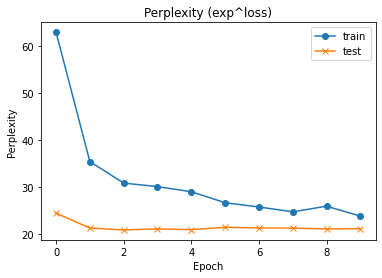

In [24]:
def plot_metric(metrics, legends, xlabel='', ylabel='', title='Plot'):
    if type(metrics) != list:
        metrics = [metrics]
    if type(legends) != list:
        legends = [legends]
    assert len(metrics) < 4, "Too many metrics. only 3 are supported."

    marker = ['o', 'x', 'd']
    i = 0
    for metric in metrics:
        plt.plot(range(len(metric)), metric, marker=marker[i])
        i+=1
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(legends)
    plt.title(title)
    plt.show()

plot_metric([train_perplexity, test_perplexity], ['train', 'test'], 'Epoch', 'Perplexity', 'Perplexity (exp^loss)')

---

In [25]:
valid_iter = iter(test_iterator)

In [26]:
sample_batch = next(valid_iter)

In [27]:
sample_batch


[torchtext.legacy.data.batch.Batch of size 128]
	[.questions]:[torch.cuda.LongTensor of size 8x128 (GPU 0)]
	[.answers]:[torch.cuda.LongTensor of size 72x128 (GPU 0)]

In [28]:
def diagnose(model, batch, output_length):
    texts = batch.questions.transpose(1,0)
    text = texts[11].unsqueeze(0)

    sentence = ' '.join([question.vocab.itos[w] for w in text[0]])

    answer_texts = batch.answers.transpose(1,0)
    answer_text = answer_texts[11].unsqueeze(0)

    with torch.no_grad():
        outputs = model(text.reshape(-1, 1).to(device), torch.zeros(output_length, 1, dtype=torch.int).to(device), 0)

    print('Sentence : ', sentence.strip())
    return outputs


output_length = 12
outputs = diagnose(model, sample_batch, output_length)
print("Shape of output : ", outputs.shape)

Sentence :  <sos> when was henri becquerel born ? <eos>
Shape of output :  torch.Size([12, 1, 597])


----

# Exp

In [ ]:
import torch
# declare embeddings
embed = torch.nn.Embedding(5,10)

# generate embedding for word [4] in vocab 
word = torch.tensor([4])

# search function for searching through embedding
def search(vector, distance_fun):
    weights = embed.weight
    min = torch.tensor(float('inf'))
    idx = -1
    v, e = weights.shape

    # each vector in embeding is corresponding to one of the word.
    # use a distance function to compare with vector
    for i in range(v):
        dist = distance_fun(vector, weights[i])
        if (min<dist):
            min = dist
            idx = i
    return i  
# searching with squared distance
search(word, lambda x,y: ((x-y)**2).sum()  